In [1]:
import numpy as np
import scipy
#Scipy imports
import scipy
from scipy import optimize
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import skimage.io
from skimage import transform, filters
import glob
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
import matplotlib.cm as cm

In [2]:
#Create normalization matrix

def norm_mat_fn(im_ref, im_dark, r_blur=3):
    """
    Generate a normalization matrix from a reference image.
    
    This function corrects for uneven illumination. It takes in a reference image which should be the zero 
    ATP control. It then finds the brightest point of the image and for each pixel replaces the pixel value 
    with (brightest pixel value)/(initial pixel value). This creates a matrix that when multiplied by the 
    original image with flatten the illumination and raise every pixel to the brightest value. You can then 
    multiply this normalization matrix by all other images in the dataset to flatten the illumination in each image.

    It is assumed that the reference image is taken for a sample with a spatially uniform protein concentration. The 
    normalization value is everywhere greater than 1, except at the position of the highest illumination.
    
    Parameters
    ----------
    im_ref : numpy array
        Reference image (e.g., the first frame in the MT channel).
    
    offset_camera : float
        Camera offset (not accounting for autofluorescence).
        
    r_blur : float
        Radius of blurring to be performed on the reference image 
        in order to remove noise and short length scale nonuniformities [px].
        
    Returns
    -------
    norm_mat : numpy array
        Normalization matrix
    """
    
    # Convert image into a float type
    im_ref = im_ref.astype(float)
    
    # Subtract the camera offset
    im = im_ref - im_dark
    
    # Rescale the image down for faster denoising
    rescale = 4.0
    im_resized = skimage.transform.rescale(im, 1/rescale)
    
    # Median filter to remove hot pixels
    im_median = skimage.filters.median(im_resized, skimage.morphology.disk(10.0))
    
    # Gaussian blur the image
    im_blur = skimage.filters.gaussian(im_median, r_blur)
    
    # Find the location of the peak
    ind_max = np.where(im_blur == im_blur.max())
    i_center, j_center = ind_max[0][0], ind_max[1][0]
    
    # Peak fluorescence in the normalization image
    fluo_peak = im_blur[i_center, j_center]
    
    # Normalization matrix
    norm_mat = fluo_peak/im_blur 
    
    # Scale up the normalization matrix to the original size
    norm_mat = skimage.transform.rescale(norm_mat, rescale)
    
    return norm_mat


In [3]:
#imaging parameters:
delt = 20 #seconds

#Subtract background
bg = 1915


# Diffusion Data

In [4]:
### Diffusion Data ###
folder_path = '../../data/maya_diffusion/2023-05-11-_MayaDiffusion_atedge_R2R3_1/pos0/'
files = np.sort(glob.glob(folder_path+'*.tif'))
ims = []
for file in files:
    im = skimage.io.imread(file).astype(np.int16)
    ims.append(im)
ims = np.array(ims) # start at frame 12
time = np.arange(len(ims))*delt # seconds

# Norm image

In [5]:
### Normalization image ###
normfile = '../../data/maya_diffusion/2023-05-11-_MayaDiffusion_atedge_R2R3_noATP_1/2023-05-11-_MayaDiffusion_atedge_R2R3_noATP_1_MMStack_Pos0.ome.tif'
normim = skimage.io.imread(normfile).astype(np.int16) 
darkim = np.ones(np.shape(normim))*bg
normmat = norm_mat_fn(normim, darkim, r_blur=10)

# Subtract Background/Normalize

In [6]:
# Subtract background
ims_bs = ims-bg

# Normalize (Flatten image)
ims_norm = ims_bs*normmat

# Calibrate

In [7]:
Imax = np.average(ims_norm, axis=(1,2)).max()
Imin = np.average((normim-bg)*normmat)
Irange = Imax - Imin
Kprobe = 80

3825.2578398698365

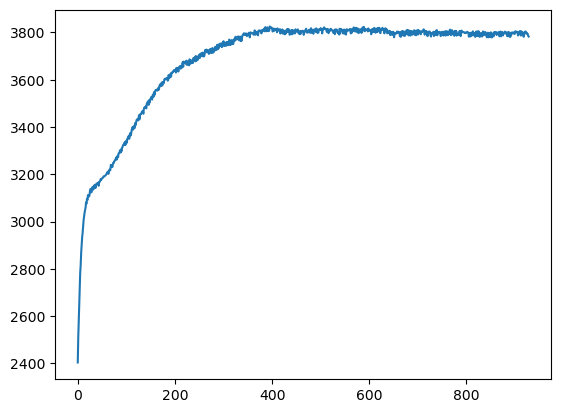

In [41]:
plt.plot(np.arange(len(ims_norm)), np.average(ims_norm[:, :, 1600:1800], axis=(1,2)))
np.average(ims_norm[:, :, 1600:1800], axis=(1,2)).max()

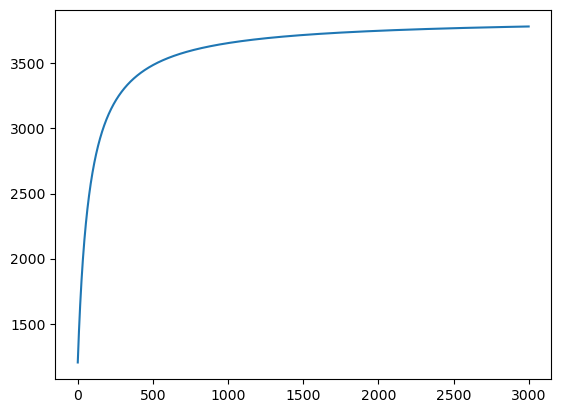

In [46]:
plt.plot(np.arange(3000), Irange*(np.arange(3000))/ (np.arange(3000) + Kprobe) + Imin)

In [8]:
def eqn_inv(inten, Kprobe, Imin, Irange):
    return Kprobe * (inten - Imin) / (Irange + Imin - inten)

In [68]:
ims_uM = eqn_inv(ims_norm[:, 200:-200, 1700:1800], Kprobe, Imin, Irange)
#ims_uM[np.where(ims_uM<0)] = 0

In [69]:
ims_uM[np.where(ims_uM<0)] = 0

(0.0, 1000.0)

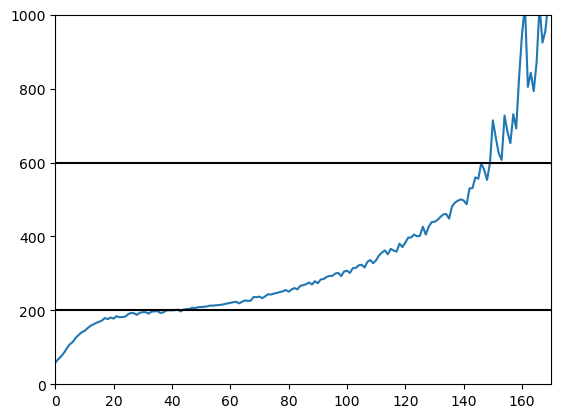

In [78]:
plt.plot(np.arange(len(ims_uM)), np.average(ims_uM, axis=(1,2)))
plt.plot(np.arange(len(ims_uM)), np.ones(len(ims_uM))*200, color='k')
plt.plot(np.arange(len(ims_uM)), np.ones(len(ims_uM))*600, color='k')
plt.xlim(0, 170)
plt.ylim(0, 1000)

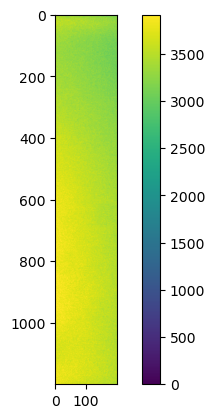

In [49]:
plt.imshow(ims_norm[150][:, 1600:1800], vmin=0, vmax=np.percentile(ims_norm[150][:, 1600:1800],99))
plt.colorbar()

In [118]:
### Diffusion Data ###
folder_path = '../../data/maya_diffusion/2023-05-11-_MayaDiffusion_atedge_R2R3_1/pos0/'
files = np.sort(glob.glob(folder_path+'*.tif'))
ims = []
for file in files:
    im = skimage.io.imread(file).astype(np.int16)
    ims.append(im)
ims = np.array(ims) # start at frame 12
time = np.arange(len(ims))*delt # seconds

### Normalization image ###
normfile = '../../data/maya_diffusion/2023-05-11-_MayaDiffusion_atedge_R2R3_noATP_1/2023-05-11-_MayaDiffusion_atedge_R2R3_noATP_1_MMStack_Pos0.ome.tif'
normim = skimage.io.imread(normfile).astype(np.int16) 
darkim = np.ones(np.shape(normim))*bg
normmat = norm_mat_fn(normim, darkim)

### Calibration Data ###
folder_path = '../../data/maya_diffusion/2023-05-19_atpcal_iATP_Maya_1/'
include = '*0001*.tif'
#find file names
files = np.sort(glob.glob(folder_path+include))
#convert file names to images
ims_cal = []
for file in files:
    im_cal = skimage.io.imread(file).astype(np.int16)
    ims_cal.append(im_cal)
#make image list an array and delete the zero ATP condition (last index)
ims_cal = ims_cal[:-1]

#import non-spotty zero data
zero_path = '../../data/maya_diffusion/2023-05-19_atpcal0ATP_iATP_Maya_1/'
include = '2023-05-19_atpcal0ATP_iATP_Maya_1_MMStack_Pos2.ome0001.tif'
zeroim = skimage.io.imread(zero_path+include).astype(np.int16)
ims_cal.append(zeroim)

ims_cal=np.array(ims_cal)


# Subtract Background (Dark image)

In [53]:
np.average(ims_cal, axis = (1,2))

array([2147.2314375 , 2188.40429167, 2199.04073611, 2256.46186806,
       2134.74106944, 2056.02640278, 2132.07129167, 2002.44611806])

In [54]:
ims_bg = ims-bg
ims_cal_bg = ims_cal - bg

# Normalize

In [55]:
ims_norm = ims_bg*normmat
ims_cal_norm = ims_cal_bg*normmat

# Create the calibration curve

In [56]:
concs = np.array([2820, 1410, 705, 353, 176, 88, 44, 0])

In [57]:
ims_cal_avg = np.average(ims_cal_norm, axis = (1,2))
ims_cal_avg

array([292.37917354, 342.80508256, 357.70128549, 429.13788536,
       275.72227999, 177.00746138, 272.49950995, 109.8020596 ])

In [58]:
def eqn(conc, K, cmin, cmax):
    return (cmax*conc / (K + conc)) + cmin

def fit(eqn, concs, intens, p0):
    params, _ = curve_fit(eqn, concs, intens, p0)
    return params

In [59]:
params = fit(eqn, concs, ims_cal_avg, [100, 100, 400])
params

array([ 53.39544969, 113.09676198, 242.14871554])

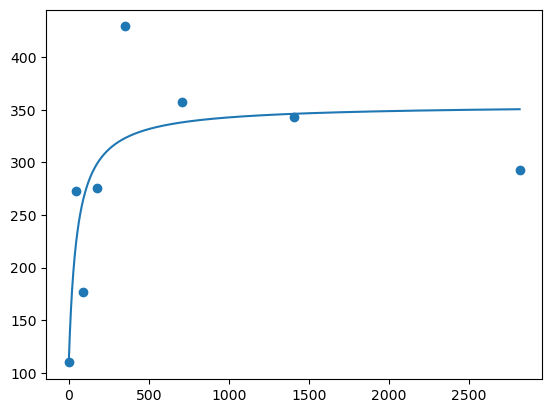

In [60]:
plt.scatter(concs, ims_cal_avg)
plt.plot(np.arange(concs.max()), eqn(np.arange(concs.max()), 53.4, 113, 242))

# Normalize the cal curve

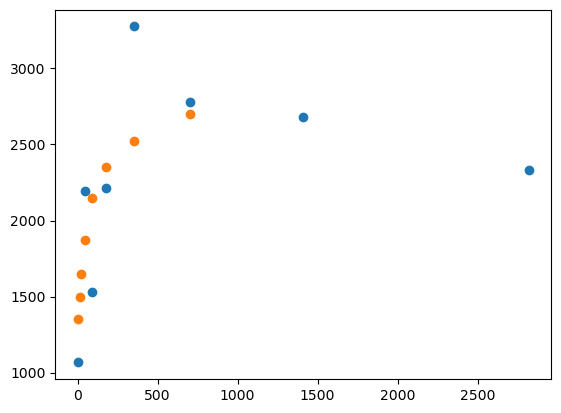

In [61]:
plt.scatter(concs, 1674*(ims_cal_avg-113)/(242) +1089)
plt.scatter(testc, testI)

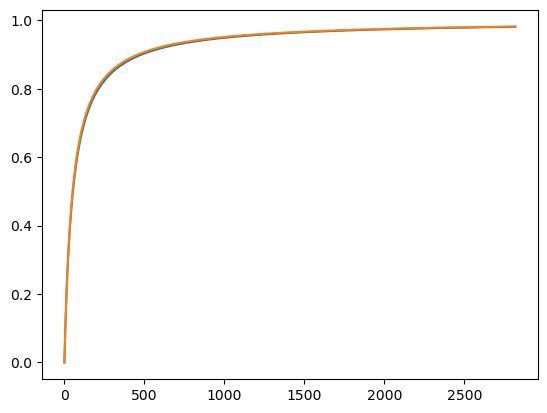

In [62]:

plt.plot(np.arange(concs.max()), eqn(np.arange(concs.max()), 53.4, 0, 1))
plt.plot(np.arange(concs.max()), eqn(np.arange(concs.max()), 50.7, 0, 1))

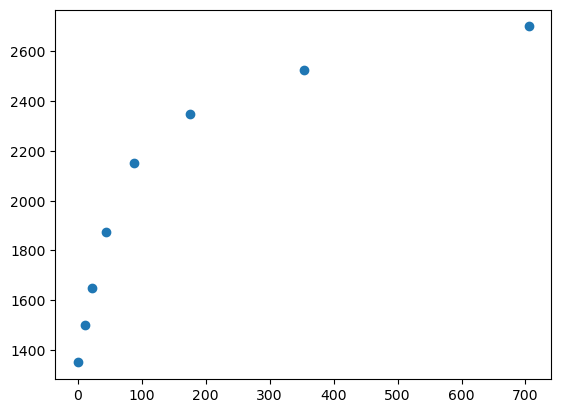

In [63]:
testI = [2700, 2525, 2350, 2150, 1875, 1650, 1500, 1350]
testc = [705, 353, 176, 88, 44, 22, 11, 0 ]
plt.scatter(testc, testI)

In [64]:
testp = fit(eqn, testc, testI, [100, 1400, 2700])
testp

array([  79.73512964, 1337.33921907, 1492.04304048])

# Subtract background

In [119]:
# Subtract background
ims_bs = ims-bg

# Normalize (Flatten image)
ims_norm = ims_bs*normmat

In [359]:
testnorm = norm_mat_fn(normim[:, 1500:], darkim[:, 1500:], r_blur=10)
testnotnorm = norm_mat_fn(ims[0][:, 1500:], darkim[:, 1500:], r_blur=3)

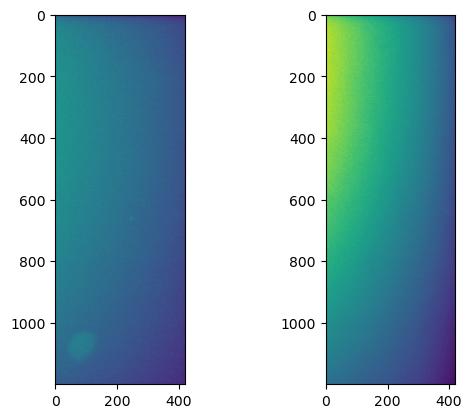

In [360]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(normim[:,1500:])
ax[1].imshow(ims_bs[0][:,1500:])

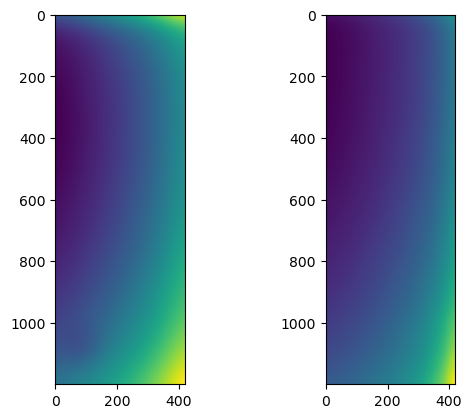

In [361]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(testnorm)
ax[1].imshow(testnotnorm)

In [362]:
ims_testnorm = ims_bs[:, :, 1500:]*testnorm

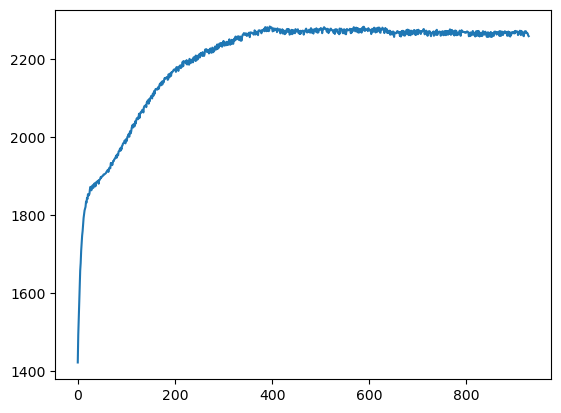

In [377]:
plt.plot(np.arange(len(ims_testnorm)), np.average(ims_testnorm, axis=(1,2)))

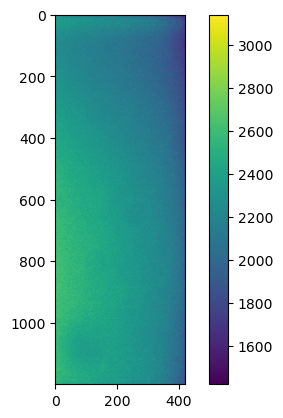

In [372]:
plt.imshow(ims_testnorm[900])
plt.colorbar()

In [392]:
ims_testuM = eqn_inv(ims_testnorm, 79.73512964, Imin, 1492+1337-Imin)


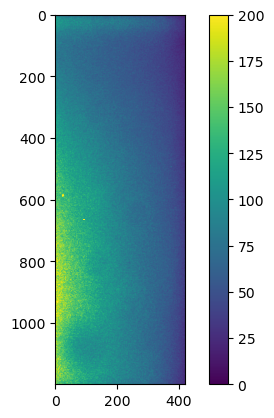

In [393]:
ims_testuM[100][np.where(ims_testuM[100]<0)] = 0
plt.imshow(ims_testuM[100], vmin = 0, vmax = 200)
plt.colorbar()

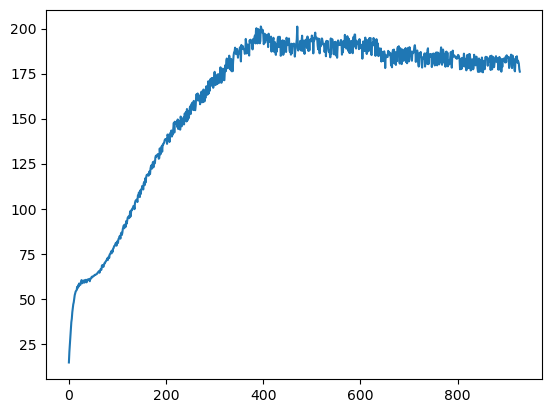

In [394]:
plt.plot(np.arange(len(ims_testuM)), np.average(ims_testuM, axis=(1,2)))

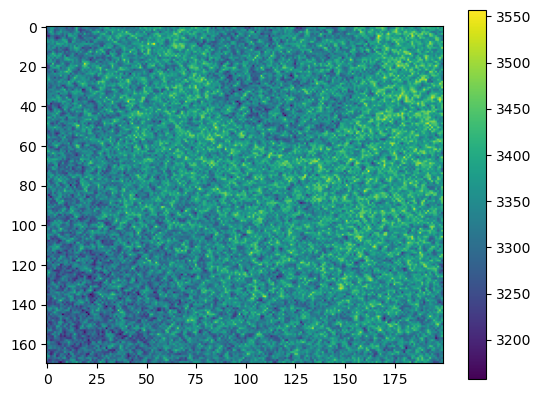

In [323]:
plt.imshow(ims_bs[100][600:1920-1150, 500:1200-500])
plt.colorbar()
#plt.scatter([600, 600, 1920-1150, 1920-1150],[500, 1200-500, 500, 1200-500])

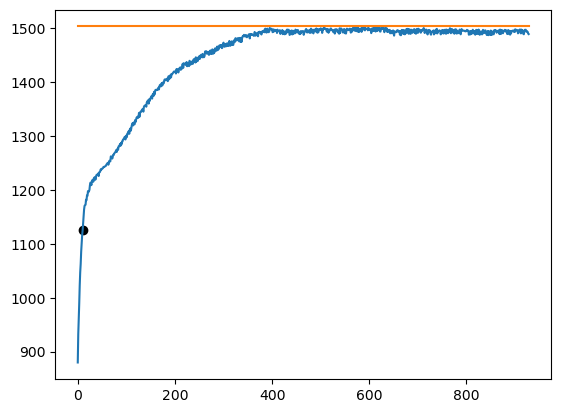

In [233]:
plt.plot(np.arange(len(ims_bs)), np.average(ims_bs[:, 200:-200, 1800:1900], axis=(1,2)))
plt.plot(np.arange(len(ims_bs)),np.average(ims_bs[:, 200:-200, 1800:1900], axis=(1,2)).max()*np.ones(len(ims_bs)))
plt.scatter(10, np.average(ims_bs[10][200:-200, 1800:1900]), color='k')

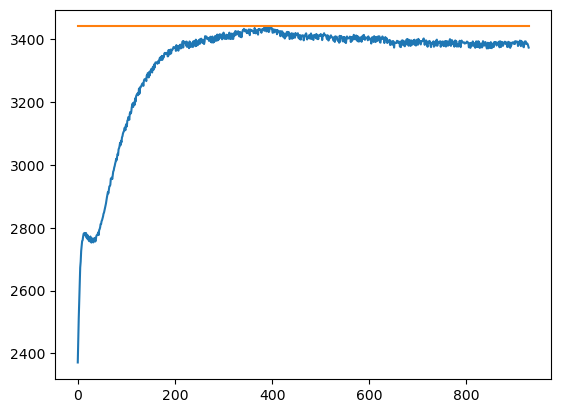

In [232]:
plt.plot(np.arange(len(ims_bs)), np.average(ims_bs[:, 200:-200, 900:1000], axis=(1,2)))
plt.plot(np.arange(len(ims_bs)),np.average(ims_bs[:, 200:-200, 900:1000], axis=(1,2)).max()*np.ones(len(ims_bs)))

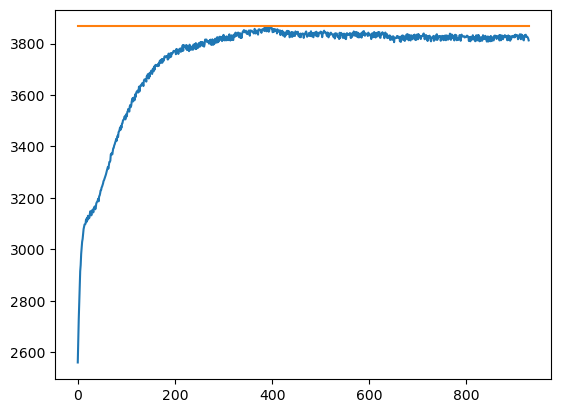

In [395]:
plt.plot(np.arange(len(ims_norm)), np.average(ims_norm, axis=(1,2)))
plt.plot(np.arange(len(ims_norm)),np.average(ims_norm, axis=(1,2)).max()*np.ones(len(ims_norm)))

In [230]:
np.max(np.average(ims_bs, axis=(1,2))), np.min(np.average(ims_bs, axis=(1,2)))

(2757.104298611111, 1860.8565208333334)

In [229]:
np.average(normim-bg)

870.2792777777778

In [130]:
Imax = np.average(ims_norm, axis=(1,2)).max()
Imin = np.average((normim-bg)*normmat)
Irange = Imax - Imin
Kprobe = testp[0]

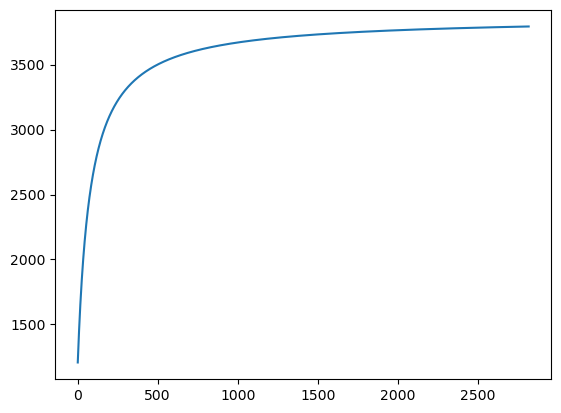

In [128]:
plt.plot(np.arange(concs.max()), eqn(np.arange(concs.max()), Kprobe, Imin, Imax-Imin))

In [131]:
def eqn_inv(inten, Kprobe, Imin, Irange):
    return Kprobe * (inten - Imin) / (Irange + Imin - inten)

In [240]:
ims_uM = eqn_inv(ims_bs[900][100:-100, 1000:1100], Kprobe, Imin, Irange)
ims_uM[np.where(ims_uM<0)] = 0

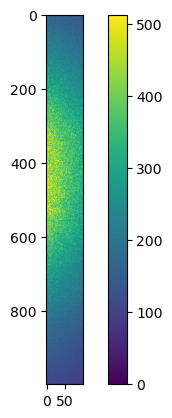

In [241]:
plt.imshow(ims_uM, vmin=0, vmax = np.percentile(ims_uM, 99))
plt.colorbar()

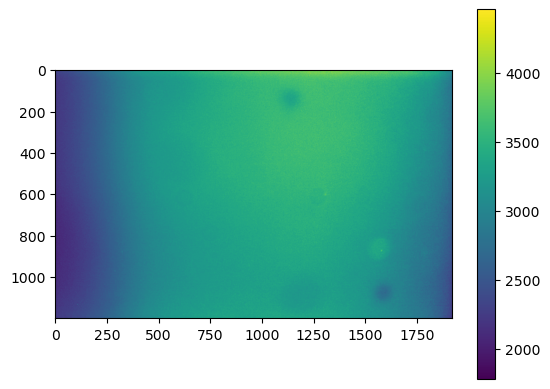

In [147]:
plt.imshow(ims_norm[25])
plt.colorbar()